## 参数更新

### demo

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设数据
x_train = torch.tensor([[1.0], [2.0], [3.0]], requires_grad=False)
y_train = torch.tensor([[2.0], [4.0], [6.0]], requires_grad=False)

# 定义一个简单的线性模型
model = nn.Linear(in_features=1, out_features=1)

# 定义损失函数
loss_fn = nn.MSELoss()

In [17]:
w = model.weight.data.item() # 获取权重参数并且转换成python数值
b = model.bias.data.item() 
w,b

(-0.13543343544006348, -0.6597474813461304)

#### 正向传播

In [21]:
# 正向传播
predictions = model(x_train)

#### 计算损失 ～ loss_fn

- nn.MSELoss()
- nn.BCEWithLogitsLoss
- nn.CrossEntropyLoss

In [24]:
# 计算损失
loss = loss_fn(predictions, y_train)

In [26]:
model.weight.data, model.bias.data

(tensor([[-0.1354]]), tensor([-0.6597]))

#### 反向传播 ～ loss.backward() 

In [29]:
model.weight.grad, model.bias.grad

(None, None)

In [31]:
# 反向传播
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()  # 清除之前的梯度
loss.backward()        # 反向传播，计算梯度

In [32]:
model.weight.grad, model.bias.grad

(tensor([[-22.5697]]), tensor([-9.8612]))

In [35]:
model.weight.data.item(), model.bias.data.item()

(-0.13543343544006348, -0.6597474813461304)

In [37]:
# 打印自动计算的梯度
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} gradient (auto): {param.grad}")

weight gradient (auto): tensor([[-22.5697]])
bias gradient (auto): tensor([-9.8612])


#### 根据梯度更新参数 ～ optimizer.step()

In [40]:
optimizer.step()  # 根据梯度更新参数

In [42]:
model.weight.data.item(), model.bias.data.item()

(0.09026357531547546, -0.5611351728439331)

In [44]:
w - model.weight.grad.item()*0.01, b - model.bias.grad.item()*0.01 # 使用梯度下降更新参数

(0.09026358604431153, -0.5611351919174195)

In [46]:
w,b

(-0.13543343544006348, -0.6597474813461304)

#### optimizer.zero_grad()

In [49]:
optimizer.zero_grad()

In [51]:
model.weight.grad, model.bias.grad

(None, None)

### 参数部分更新

网络结构：https://alexlenail.me/NN-SVG/index.html

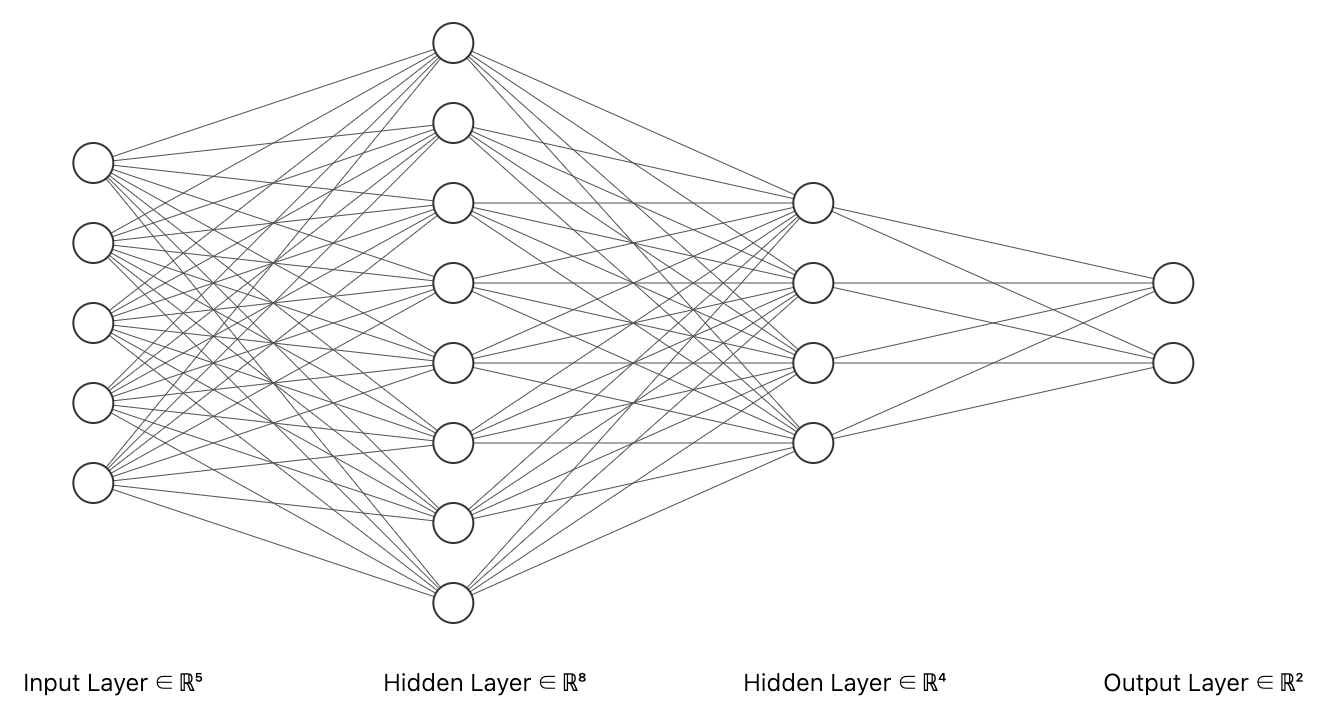

In [55]:
import torch
import torch.nn as nn

x = torch.rand(5, 8)  # [5,8]
w1_tensor = torch.rand(6, 4)  # 参数不更新
w1_parameter = nn.Parameter(torch.rand(2, 4))  # 希望更新的 创建随机张量形状为（2，4），包装为parameter对象
w1 = torch.concat([w1_tensor, w1_parameter], dim=0)  # [8,4] 我希望前6行进行参数不更新，后2行参数更新
w2 = nn.Parameter(torch.rand(4, 2))  # [4,2]

#### 前向过程

In [58]:
# 前向过程
z1 = torch.matmul(x, w1)  # [5,8] * [8,4] = [5,4]
z2 = torch.matmul(z1, w2)  # [5,4] * [4,2] = [5,2]
loss = torch.sum(z2)  # [5,2] -> [1]

#### retain_grad
- 保留梯度：当你对一个张量调用retain_grad()后，该张量的梯度在反向传播后不会被自动清零，而是会被保留下来。

- 累积梯度：如果你在一个训练循环中多次执行反向传播，但没有在每次迭代后更新权重（例如，为了进行梯度累积），retain_grad()可以确保梯度被累积而不是被覆盖。

In [61]:
# 保留z1和z2的梯度，方便查看
w1.retain_grad()
z1.retain_grad()
z2.retain_grad()

#### 反向过程

In [64]:
# 反向过程
print(x.grad)
print(w1.grad)
print(w2.grad)
loss.backward()

None
None
None


In [66]:
print(x.grad)
print(w1.grad)
print(w2.grad)

None
tensor([[2.7408, 2.5876, 1.0278, 2.8195],
        [4.6646, 4.4038, 1.7492, 4.7985],
        [2.1412, 2.0215, 0.8030, 2.2027],
        [2.1858, 2.0636, 0.8197, 2.2485],
        [3.0266, 2.8574, 1.1349, 3.1135],
        [2.2816, 2.1541, 0.8556, 2.3471],
        [3.6366, 3.4333, 1.3637, 3.7410],
        [4.7002, 4.4374, 1.7625, 4.8351]])
tensor([[ 6.7579,  6.7579],
        [11.5218, 11.5218],
        [10.3894, 10.3894],
        [10.7534, 10.7534]])


In [68]:
print(z1.grad)
print(z2.grad)
print(w1_tensor.grad)
print(w1_parameter.grad)

tensor([[1.2509, 1.1810, 0.4691, 1.2868],
        [1.2509, 1.1810, 0.4691, 1.2868],
        [1.2509, 1.1810, 0.4691, 1.2868],
        [1.2509, 1.1810, 0.4691, 1.2868],
        [1.2509, 1.1810, 0.4691, 1.2868]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])
None
tensor([[3.6366, 3.4333, 1.3637, 3.7410],
        [4.7002, 4.4374, 1.7625, 4.8351]])


### is_leaf

In [72]:
a = torch.tensor(2.0)
b = torch.tensor(3.0, requires_grad=True)
c = a * b

print(c)

tensor(6., grad_fn=<MulBackward0>)


### is_leaf

- 含义：is_leaf属性是一个布尔值，用来指示一个张量是否是叶子节点。在PyTorch的自动微分系统中，叶子节点是指直接由用户创建且没有梯度的张量，或者是从torch.autograd.Function派生出来的函数的输出。简而言之，叶子节点是那些在计算图(表示数据流动，操作的有向图）中不由其他节点计算得到的张量。

In [75]:
print(a.is_leaf)
print(b.is_leaf)
print(c.is_leaf)

True
True
False


### requires_grad

- 含义：requires_grad属性也是一个布尔值，用来指示是否需要计算该张量的梯度。如果设置为True，则在反向传播时，PyTorch会计算并存储该张量的梯度。

- 用途：当你想要对某个张量进行梯度计算时，你需要将requires_grad设置为True。这通常用于模型的参数，因为我们需要对这些参数进行梯度更新以训练模型。

In [78]:
print(a.requires_grad)
print(b.requires_grad)
print(c.requires_grad)

False
True
True


In [80]:
b.requires_grad=False
print(b.requires_grad)

False


PyTorch中三种常用的优化算法:`torch.optim.SGD`、`torch.optim.RMSprop`和`torch.optim.Adam`

## 1. SGD（随机梯度下降）
SGD是最基础的优化算法，它按照梯度方向更新参数，每次迭代更新的步长由学习率决定。

**更新公式：**
$$ \theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t) $$

其中：
- $ \theta_t $ 是当前的参数值。
- $ \eta $ 是学习率。
- $ \nabla_\theta J(\theta_t) $ 是关于参数的损失函数的梯度。

**PyTorch代码示例：**
```python
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

## 2. RMSprop
RMSprop是一种自适应学习率的优化算法，它通过调整每个参数的学习率来加速收敛。它使用梯度的平方的指数加权移动平均来调整学习率。

**更新公式：**
$$ s_t = \rho \cdot s_{t-1} + (1 - \rho) \cdot (\nabla_\theta J(\theta_t))^2 $$
$$ \hat{s}_t = s_t / (1 - \rho^t) $$
$$ \theta_{t+1} = \theta_t - \eta \cdot \frac{\nabla_\theta J(\theta_t)}{\sqrt{\hat{s}_t} + \epsilon} $$

$ \rho $越小，越考虑近期情况

其中：
- $ s_t $ 是梯度平方的累积变量。
- $ \rho $ 是梯度平方的衰减率（通常设置为0.9）。
- $ \hat{s}_t $ 是偏差校正后的累积变量。
- $ \epsilon $ 是一个很小的常数，用于防止分母为零。

**PyTorch代码示例：**
```python
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
```

## 3. Adam
Adam是一种结合了Adagrad和RMSprop的自适应学习率优化算法，它同时考虑了梯度的一阶矩和二阶矩（梯度的平方）。

**更新公式：**
$$ m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla_\theta J(\theta_t) $$
$$ v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla_\theta J(\theta_t))^2 $$
$$ \hat{m}_t = m_t / (1 - \beta_1^t) $$
$$ \hat{v}_t = v_t / (1 - \beta_2^t) $$
$$ \theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $$

其中：
- $ m_t $ 是梯度的一阶矩估计。
- $ v_t $ 是梯度的二阶矩估计。
- $ \beta_1 $ 和 $ \beta_2 $ 分别是一阶和二阶矩的衰减率（通常设置为0.9和0.999）。
- $ \hat{m}_t $ 和 $ \hat{v}_t $ 是偏差校正后的一阶和二阶矩估计。

**PyTorch代码示例：**
```python
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

在这些优化器中，学习率（`lr`）是一个关键的超参数，它控制着每次更新的步长。自适应学习率的优化器（如RMSprop和Adam）能够根据参数的历史梯度自动调整学习率，这通常有助于模型更快地收敛。


## vs

online_shopping_10_cats.csv
数据集"online_shopping_10_cats.csv"包含六万多条购物评价，这些评价分别来自十个不同的类别：书籍、平板、手机、水果、洗发水、热水器、蒙牛、衣服、计算机和酒店。该数据集中的每条评论都标注了其所属的类别，并且每行数据包含三列：类型（cat）、是否是正面评价（label，其中1代表正面评价，0代表负面评价）以及评论文本（review）。正向和负向评论各约有三万条。

SGD Epoch [1/10], Loss: 2.2887
RMSprop Epoch [1/10], Loss: 2.2666
Adam Epoch [1/10], Loss: 11.9257
SGD Epoch [2/10], Loss: 3.5036
RMSprop Epoch [2/10], Loss: 2.8836
Adam Epoch [2/10], Loss: 14.2390
SGD Epoch [3/10], Loss: 9.2906
RMSprop Epoch [3/10], Loss: 7.2791
Adam Epoch [3/10], Loss: 4.8842
SGD Epoch [4/10], Loss: 2.5689
RMSprop Epoch [4/10], Loss: 1.7075
Adam Epoch [4/10], Loss: 0.0066
SGD Epoch [5/10], Loss: 0.0002
RMSprop Epoch [5/10], Loss: 0.0002
Adam Epoch [5/10], Loss: 0.0000
SGD Epoch [6/10], Loss: 0.0002
RMSprop Epoch [6/10], Loss: 0.0002
Adam Epoch [6/10], Loss: 0.0000
SGD Epoch [7/10], Loss: 0.0001
RMSprop Epoch [7/10], Loss: 0.0001
Adam Epoch [7/10], Loss: 0.0000
SGD Epoch [8/10], Loss: 0.0001
RMSprop Epoch [8/10], Loss: 0.0001
Adam Epoch [8/10], Loss: 0.0000
SGD Epoch [9/10], Loss: 0.0001
RMSprop Epoch [9/10], Loss: 0.0001
Adam Epoch [9/10], Loss: 0.0000
SGD Epoch [10/10], Loss: 0.0001
RMSprop Epoch [10/10], Loss: 0.0001
Adam Epoch [10/10], Loss: 0.0000


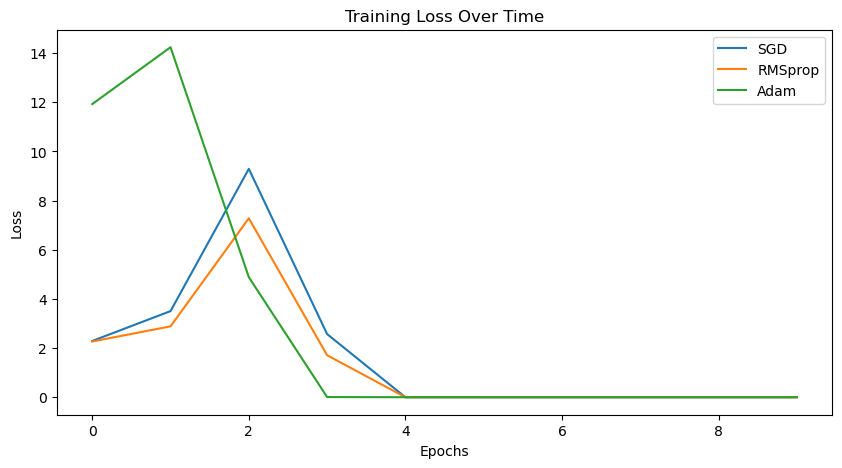

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 设定设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义一个简单的多层感知器模型
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential( # 定义顺序容器，包含模型各层
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)  # 将模型移动到选定的设备上

# 创建三个优化器实例
learning_rate = 0.03
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=learning_rate),
    'RMSprop': optim.RMSprop(model.parameters(), lr=learning_rate),
    'Adam': optim.Adam(model.parameters(), lr=learning_rate)
}

# 模拟数据集
input_size = 100
output_size = 10
batch_size = 32
X = torch.randn(batch_size, input_size).to(device)  # 随机输入数据
y = torch.randint(output_size, (batch_size,)).to(device)  # 随机标签

# 损失函数
loss_fn = nn.CrossEntropyLoss()

# 初始化存储损失的字典
loss_records = {name: [] for name in optimizers.keys()}

# 训练循环

num_epochs = 10
for epoch in range(num_epochs):
    for name, optimizer in optimizers.items():
        # 前向传播
        outputs = model(X)
        loss = loss_fn(outputs, y)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失值
        loss_records[name].append(loss.item())

        print(f"{name} Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 绘制损失曲线
plt.figure(figsize=(10, 5))
for name, losses in loss_records.items():
    plt.plot(range(len(losses)), losses, label=f'{name}')

plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()